In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import seaborn as sns

# figure style setup
sns.set(font_scale=1.5)
sns.set_style("white")
(width, legend_font) = (3, 16)
(c1, c2, c3, c4) = ("#d7191c", "#fdae61", "#2c7bb6", "#abd9e9")

In [3]:
# set path to data files 
path = './data/'

# Architecture

### service-history.csv
contains data describing number of instances over time (03/01/2021 - 12/21/2022). Three dates are missing due to corrupted data. 
* `ds`: date (yyyy-mm-dd)
* `num_regular_instances`: total number of deployed instances for regular services on ds
* `num_illfitting_instances`: total number of deployed instances for illfitting services on ds
* `num_regular_services`: total number of unique regular service names on ds
* `num_illfitting_services`: total number of unique illfitting service names on ds
- `num_regular_creation`: number of regular service ids created on ds (i.e. never existed before ds)
- `num_illfitting_creation`: number of illfitting service ids created on ds
- `num_regular_deprecation`: number of regular service ids deprecated on ds (i.e. never exist after ds)
- `num_illfitting_deprecation`: number of illfitting service ids deprecated on ds

Regular and illfitting are mutually exclusive so they can be summed to get the total across all services. 

Service id and service name used interchangably, both referring to a unique identifier for a service (e.g. Authentication).

In [4]:
service_history = pd.read_csv(path + 'service-history.csv')
service_history['num_total_instances'] = service_history['num_regular_instances'] + service_history['num_illfitting_instances']
service_history['num_total_services'] = service_history['num_regular_services'] + service_history['num_illfitting_services']

# format ds for plotting
service_history['ds'] = pd.to_datetime(service_history["ds"]).tolist()

service_history.head(3)

,num_regular_instances,num_regular_services,ds,num_illfitting_instances,num_illfitting_services,num_regular_deprecation,num_illfitting_deprecation,num_regular_creation,num_illfitting_creation,num_total_instances,num_total_services
0,9572258.0,7134.0,2022-06-22,721335.0,9891.0,8,425,17,663,10293593.0,17025.0
1,11217130.0,7476.0,2022-12-20,1113477.0,11249.0,5,361,9,78,12330607.0,18725.0
2,8175158.0,6070.0,2021-08-26,355493.0,7911.0,8,65,26,623,8530651.0,13981.0


### service-characteristics.csv
contains data about all deployed services on 12/21/2022. There is one row per unique service name.
* `service_id`: anonymized service name 
* `service_type`: regular or illfitting
* `num_instances`: total number of deployed instances for the specific service (on 12/21)
* `num_fan_out_reg`: number of regular services called by this service
* `num_fan_in_reg`: number of regular services this service is called by
* `num_fan_out_ill`: number of illfitting services called by this service
* `num_fan_in_ill`: number of illfitting services this service is called by
* `num_fan_out_all`: number of services called by this service
* `num_fan_in_all`: number of services this service is called by

fan_in and fan_out metrics are based on a dependency diagram view (where each node is a unique service name and nodes are connected if there is communication between the services. If service A calls B, then there is an edge from A to B). 

'Number of services' means number of unique services names (not instances).

Anonymized service names are consistent across datasets. `service_id` 12345 always refers to the same service name. 

In [5]:
service_characteristics = pd.read_csv(path + 'service-characteristics.csv')
service_characteristics.head(3)

,service_type,service_id,num_instances,num_fan_out_reg,num_fan_in_reg,num_fan_out_ill,num_fan_in_ill,num_fan_in_all,num_fan_out_all
0,regular,0,238,26,18,0,0,18,26
1,regular,1,322,35,33,0,0,33,35
2,regular,2,1,1,0,0,0,0,1


### service-endpoints.csv
contains data about all deployed services on 12/21/2022 that communicate using Thrift RPC. There is one row per unique service name.
* `service_id`: anonymized service name 
* `service_type`: regular or illfitting
* `num_endpoints`: number of unique thrift rpc endpoints accessed in this service (on 12/21)

Note: not all services communicate via Thrift RPCs (so there are less services in this table than the other two tables).

In [6]:
service_endpoints = pd.read_csv(path + 'service-endpoints.csv')
service_endpoints.head(3)

,service_type,service_id,num_endpoints
0,illfitting,18486,2
1,regular,71,3
2,regular,3137,4


## Figure 3: Service ID replication factors

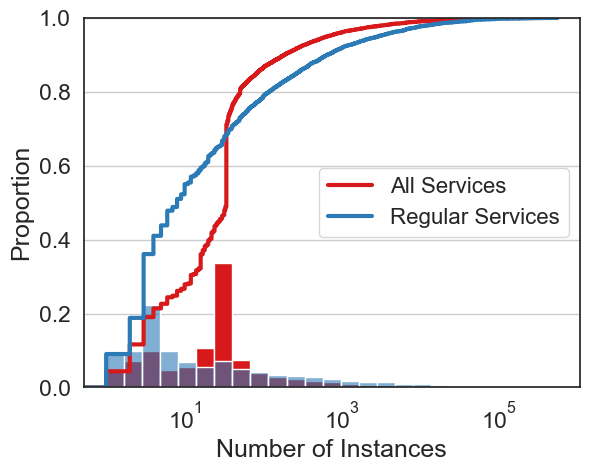

In [7]:
fig, ax = plt.subplots()

ax = sns.ecdfplot(data=service_characteristics, x="num_instances", ax=ax, color=c1, linewidth=width, label='All Services')
sns.ecdfplot(data=service_characteristics[service_characteristics['service_type'] == 'regular'], x="num_instances", ax=ax, color=c3, linewidth=width, label='Regular Services')

sns.histplot(data=service_characteristics, x="num_instances", stat='probability', log_scale=True, color=c1, bins=25, ax=ax, alpha=1)
sns.histplot(data=service_characteristics[service_characteristics['service_type'] == 'regular'], x="num_instances", stat='probability', color=c3, bins=25, ax=ax, alpha=0.6)

plt.xlabel('Number of Instances')
plt.legend(fontsize=legend_font, loc='center right')
ax.grid(axis='y')
plt.show()

## Figure 4: service fan-in and fan-out

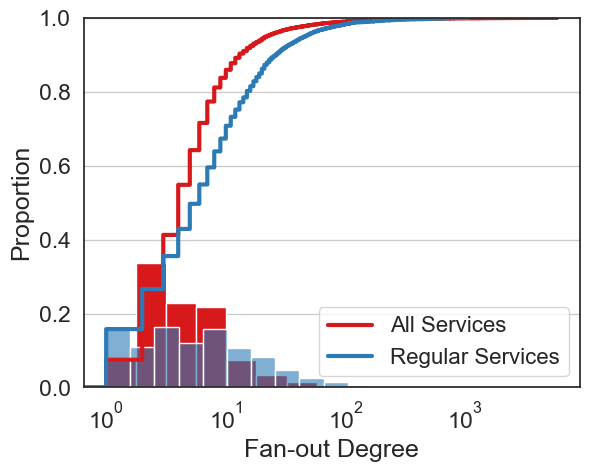

In [8]:
# filter out services that have 0 fan-out
service_characteristics_out = service_characteristics[service_characteristics['num_fan_out_all'] > 0]

fig, ax = plt.subplots()

ax = sns.ecdfplot(data=service_characteristics_out, x="num_fan_out_all", ax=ax, color=c1, linewidth=width, label='All Services')
sns.ecdfplot(data=service_characteristics_out[service_characteristics_out['service_type'] == 'regular'], x="num_fan_out_reg", ax=ax, color=c3, linewidth=width, label='Regular Services')

sns.histplot(data=service_characteristics_out, x="num_fan_out_all", stat='probability', log_scale=True, color=c1, bins=15, ax=ax, alpha=1)
sns.histplot(data=service_characteristics_out[service_characteristics_out['service_type'] == 'regular'], x="num_fan_out_reg", stat='probability', log_scale=True, color=c3, bins=15, ax=ax, alpha=0.6)

plt.legend(fontsize=legend_font)
plt.xlabel('Fan-out Degree')

ax.grid(axis='y')
plt.show()

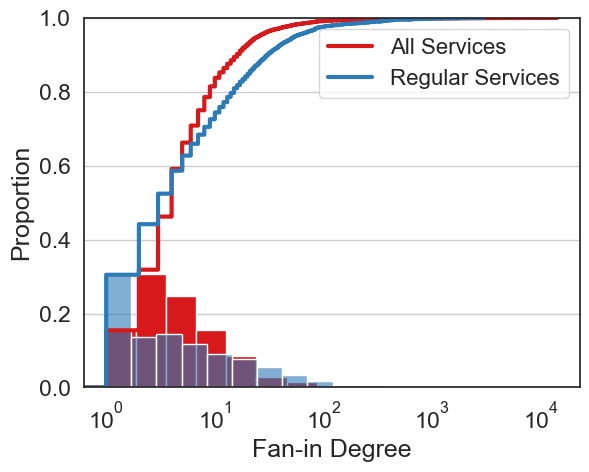

In [9]:
# filter out services that have 0 fan-out
service_characteristics_in = service_characteristics[service_characteristics['num_fan_in_reg'] > 0]

fig, ax = plt.subplots()

ax = sns.ecdfplot(data=service_characteristics_in, x="num_fan_in_all", ax=ax, color=c1, linewidth=width, label='All Services')
sns.ecdfplot(data=service_characteristics_in[service_characteristics_in['service_type'] == 'regular'], x="num_fan_in_reg", ax=ax, color=c3, linewidth=width, label='Regular Services')

sns.histplot(data=service_characteristics_in, x="num_fan_in_all", stat='probability', log_scale=True, color=c1, bins=15, ax=ax, alpha=1)
sns.histplot(data=service_characteristics_in[service_characteristics_in['service_type'] == 'regular'], x="num_fan_in_reg", stat='probability', log_scale=True, color=c3, bins=15, ax=ax, alpha=0.6)

plt.legend(fontsize=legend_font)
plt.xlabel('Fan-in Degree')

ax.grid(axis='y')
plt.show()

## Figure 5: number of endpoints exposed by services 

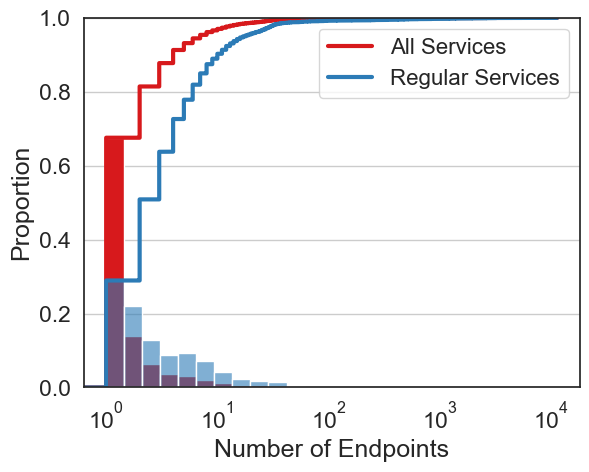

In [10]:
fig, ax = plt.subplots()

ax = sns.ecdfplot(data=service_endpoints, x="num_endpoints", ax=ax, color=c1, linewidth=width, label='All Services')
sns.ecdfplot(data=service_endpoints[service_endpoints['service_type'] == 'regular'], x="num_endpoints", ax=ax, color=c3, linewidth=width, label='Regular Services')

sns.histplot(data=service_endpoints, x="num_endpoints", stat='probability', log_scale=True, color=c1, bins=25, ax=ax, alpha=1)
sns.histplot(data=service_endpoints[service_endpoints['service_type'] == 'regular'], x="num_endpoints", stat='probability', log_scale=True, color=c3, bins=25, ax=ax, alpha=0.6)

plt.legend(fontsize=legend_font)
plt.xlabel('Number of Endpoints')

ax.grid(axis='y')
plt.show()

## Figure 6: Total service instances over time

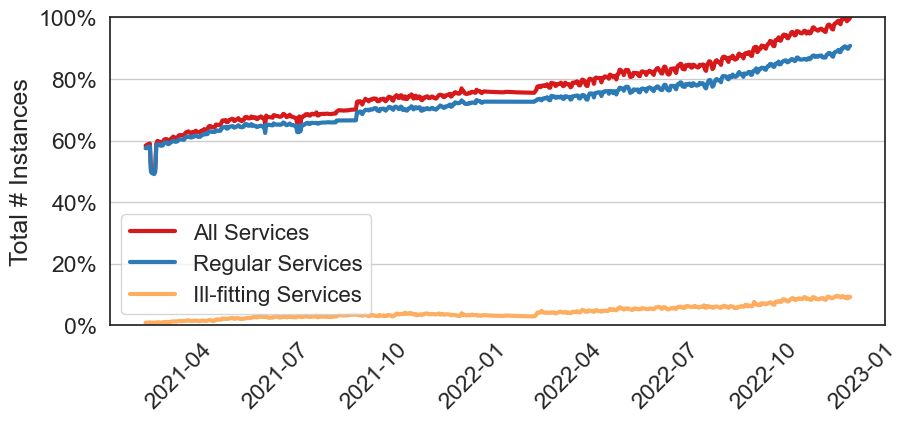

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=service_history, x="ds", y="num_total_instances", linewidth=width, color=c1, label="All Services")
sns.lineplot(data=service_history, x="ds", y="num_regular_instances", linewidth=width, color=c3, label="Regular Services")
sns.lineplot(data=service_history, x="ds", y="num_illfitting_instances", linewidth=width, color=c2, label="Ill-fitting Services")


plt.xticks(rotation=45)
max_instances = int(max(service_history['num_total_instances']))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=max_instances))
plt.ylim(0, max_instances)
plt.yticks(range(0, max_instances + 10000, int(max_instances/5)))

plt.xlabel("")
plt.ylabel("Total # Instances")
plt.legend(fontsize=legend_font)
ax.grid(axis='y')
plt.show()

## Figure 7: service IDs over time

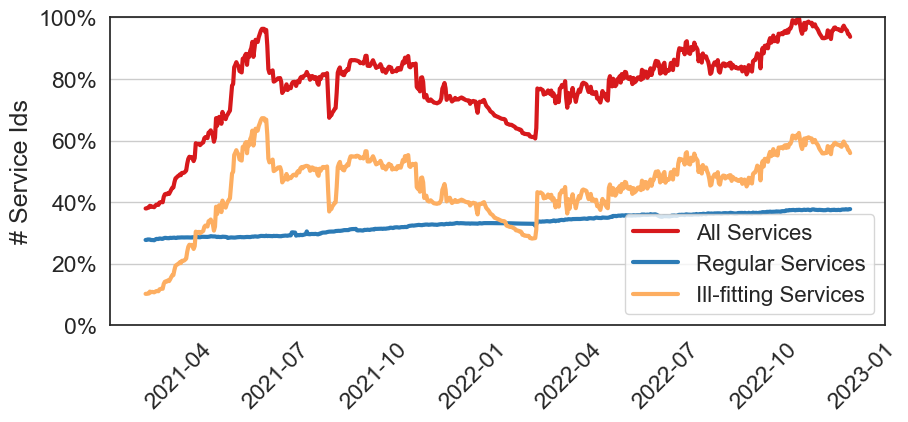

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = sns.lineplot(data=service_history, x="ds", y="num_total_services", linewidth=width, color=c1, label='All Services')
sns.lineplot(data=service_history, x="ds", y="num_regular_services", linewidth=width, color=c3, label='Regular Services')
sns.lineplot(data=service_history, x="ds", y="num_illfitting_services", linewidth=width, color=c2, label="Ill-fitting Services")

plt.xticks(rotation=45)
max_services = int(max(service_history['num_total_services']))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=max_services))
plt.ylim(0, max_services)
plt.yticks(range(0, max_services, int(max_services/5)))
ax.grid(axis='y')
plt.legend(fontsize=legend_font, loc='lower right')
plt.xlabel("")
plt.ylabel("# Service Ids")
plt.show()

## Figure 8: service ID creation and deprecation

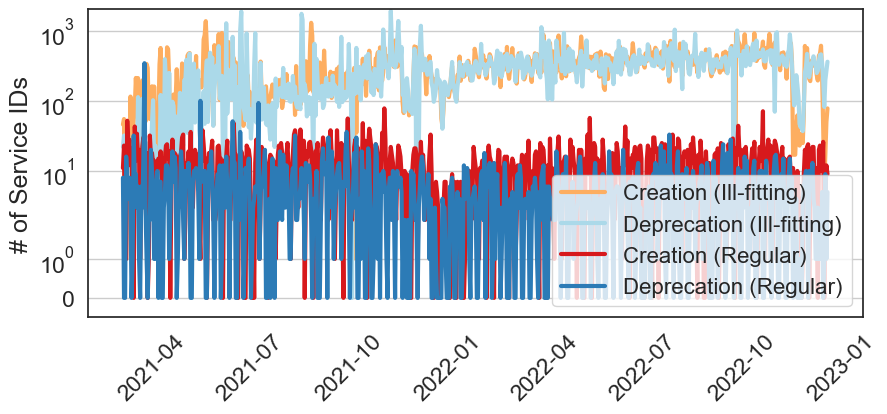

In [13]:
# filter out first 4 days and last 1 day since all services marked as deprecated on the last day and new services were slowly onboarded to data collection 
service_history_creation_dep = service_history[service_history['ds'] > '2021-03-04']
service_history_creation_dep = service_history_creation_dep[service_history_creation_dep['ds'] < '2022-12-21']

fig, ax = plt.subplots(figsize=(10, 4))
ax = sns.lineplot(data= service_history_creation_dep, x="ds", y="num_illfitting_creation", linewidth=width, color=c2, label="Creation (Ill-fitting)")
sns.lineplot(data = service_history_creation_dep, x="ds", y="num_illfitting_deprecation", linewidth=width, color=c4, label="Deprecation (Ill-fitting)")
sns.lineplot(data=service_history_creation_dep, x="ds", y="num_regular_creation", linewidth=width, color=c1, label="Creation (Regular)")
sns.lineplot(data=service_history_creation_dep, x="ds", y="num_regular_deprecation", linewidth=width, color=c3, label="Deprecation (Regular)")

plt.xticks(rotation=45)

plt.xlabel("")
plt.ylabel("# of Service IDs")
plt.yscale("symlog")
ax.grid(axis="y")
plt.legend(fontsize=legend_font, loc='lower right')
plt.ylim(-0.5)

plt.show()

# Workflows

### trace-data.csv
contains data describing traces collected on 12/21/2022 from our three trace profiles. There is one row per trace. 
* `profile`: ads, fetch, or raas
* `trace_size`: number of service blocks contained in the trace
* `num_services`: number of unique service names in the trace
* `call_depth`: maximum depth of all call paths in the trace
* `max_width`: maximum number of calls made at any depth in the trace

In [14]:
trace_data = pd.read_csv(path + 'trace-data.csv.gz')
trace_data.head(3)

,trace_size,num_services,call_depth,max_width,profile
0,2579,15,4.0,460,ads
1,3315,37,7.0,501,ads
2,84,8,5.0,7,ads


### inferred-path-data.csv
contains data decribing the number of call paths that are prematurely terminated (i.e. end at an inferred service) at each depth in the traces. There is one row per call depth in traces from a profile (if the deepest Ads trace is 10, there will be 10 rows corresponding to depth 1, 2, 3, ... 10). 
* `profile`: ads, fetch, or raas
* `call_depth`: all call depths observed across traces for a profile
* `percent_inferred_total`: percent of paths that are terminated at an inferred service at the given call depth. 
* `percent_inferred_known`: percent of paths that are terminated at an inferred service that is known to be a database (i.e. leaf in the trace) at the given call depth.

In [15]:
inferred_path_data = pd.read_csv(path + 'inferred-path-data.csv')
inferred_path_data.head(3)

,call_depth,profile,percent_inferred_total,percent_inferred_known
0,10.0,ads,32.250697,0.021380
1,6.0,ads,48.796152,20.094727
2,13.0,ads,29.650026,0.000000


### parent-data.csv
contains data decribing function invocations in a subset of our traces. There is one row per invocation of a parent (e.g. a row for each call to Authentication-login in our traces). 
* `profile`: ads, fetch, or raas
* `parent_name`: anonymized name for a nodes service name - endpoint name (*ingress id*). Anonymized names are consist and correspond to the service names in the Architecture data sets. For example, parent_name 12345-00001 is composed of service id 12345 and endpoint 00001.
* `children_set`: set containing all anonymized children *ingress id*s called by this invocation of the parent. Anonymized names are consistent across children. For example, child AAAA always corresponds to the same *ingress id*. 
* `c_set_index`: integer assigned to each unique children set, used for plotting. Ranges from 1 to n where n is number of unique children sets. 1 corresponds to the children set with the most invocations and n is the children set with the elast invocations. 
* `num_calls`: number of calls issued by the parent
* `num_returning_calls`: number of calls with observed responses issued by the parent. Calls may not return for various reasons including the call path terminating in an inferred service.  
* `concurrency_rate`: as defined in section 4.4 

In [16]:
parent_data = pd.read_csv(path + 'parent-data.csv.gz')
parent_data.head(5)

,parent_name,children_set,c_set_index,num_calls,num_returning_calls,concurrency_rate,profile
0,05593-00001,set(),1,0,0,0.0,ads
1,05593-00001,set(),1,0,0,0.0,ads
2,18620-00001,set(),1,0,0,0.0,ads
3,10424-00001,{'AACD'},1,1,1,0.0,ads
4,06339-00001,{'AACD'},1,1,1,0.0,ads


## Figure 10: Trace size

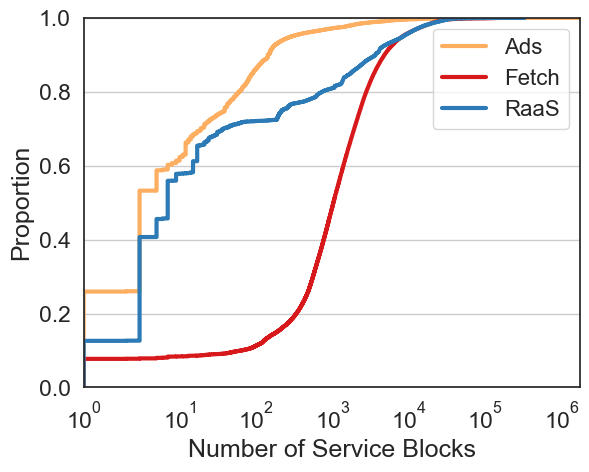

In [17]:
fig, ax = plt.subplots()
ax = sns.ecdfplot(data=trace_data[trace_data['profile'] == 'ads'], x="trace_size", ax=ax, linewidth=width, color = c2, label='Ads')
sns.ecdfplot(data=trace_data[trace_data['profile'] == 'fetch'], x="trace_size", ax=ax, linewidth=width, color = c1, label='Fetch')
sns.ecdfplot(data=trace_data[trace_data['profile'] == 'raas'], x="trace_size", ax=ax, linewidth=width, color = c3, label='RaaS')

plt.xlim(1, trace_data["trace_size"].max())
plt.xscale("symlog")
plt.xlabel('Number of Service Blocks')
plt.legend(fontsize=legend_font)
ax.grid(axis='y')
plt.show()

## Figure 11: call depth

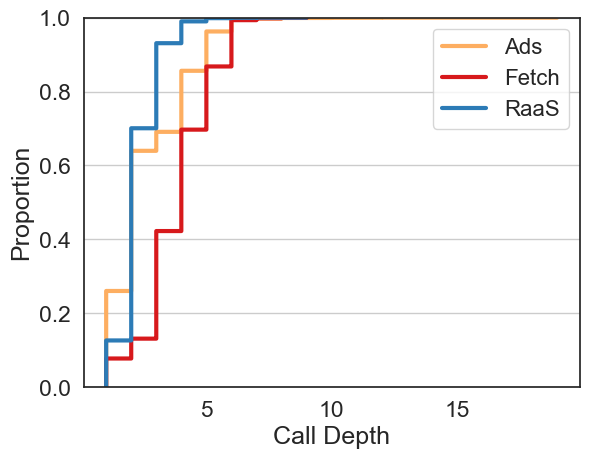

In [18]:
fig, ax = plt.subplots()

sns.ecdfplot(data=trace_data[trace_data['profile'] == 'ads'], x="call_depth", color=c2, ax=ax, linewidth=width, label='Ads')
sns.ecdfplot(data=trace_data[trace_data['profile'] == 'fetch'], x="call_depth", color=c1, ax=ax, linewidth=width, label='Fetch')
sns.ecdfplot(data=trace_data[trace_data['profile'] == 'raas'], x="call_depth", color=c3, ax=ax, linewidth=width, label='RaaS')

plt.xlabel('Call Depth')
plt.legend(fontsize=legend_font)
ax.grid(axis='y')
plt.show()

## Figure 12: Max width

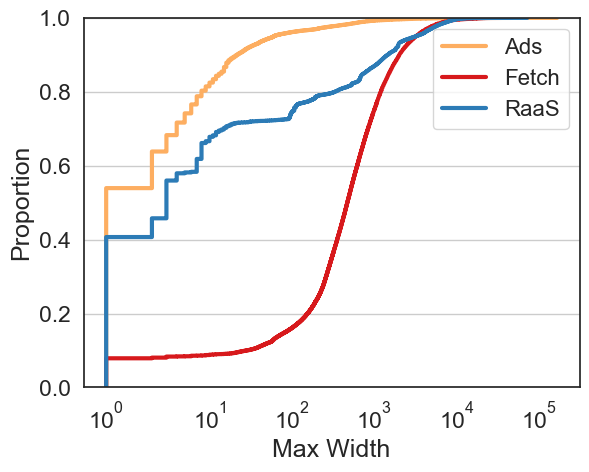

In [19]:
fig, ax = plt.subplots()

sns.ecdfplot(data=trace_data[trace_data['profile'] == 'ads'], x="max_width", ax=ax, color=c2, linewidth=width, label='Ads')
sns.ecdfplot(data=trace_data[trace_data['profile'] == 'fetch'], x="max_width", ax=ax, color=c1, linewidth=width, label='Fetch')
sns.ecdfplot(data=trace_data[trace_data['profile'] == 'raas'], x="max_width", ax=ax, color=c3, linewidth=width, label='RaaS')
plt.legend(fontsize=legend_font)
plt.xlabel('Max Width')

ax.grid(axis='y')
plt.xscale('symlog')
plt.show()

## Figure 13: Unique services 

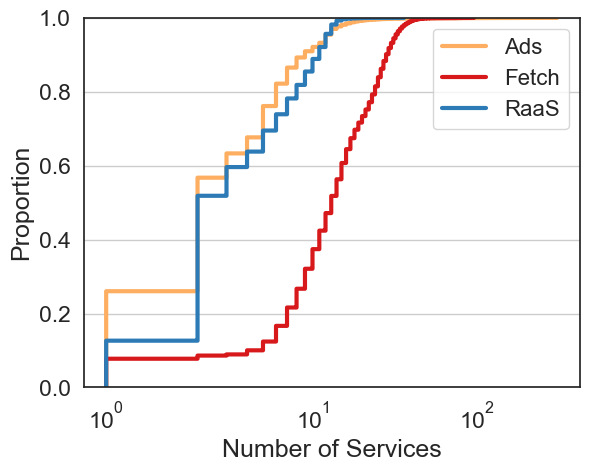

In [20]:
fig, ax = plt.subplots()

sns.ecdfplot(data=trace_data[trace_data['profile'] == 'ads'], x="num_services", color=c2, ax=ax, linewidth=width, label='Ads')
sns.ecdfplot(data=trace_data[trace_data['profile'] == 'fetch'], x="num_services", color=c1, ax=ax, linewidth=width, label='Fetch')
sns.ecdfplot(data=trace_data[trace_data['profile'] == 'raas'], x="num_services", color=c3, ax=ax, linewidth=width, label='RaaS')

plt.xscale("symlog")
plt.xlabel('Number of Services')
plt.legend(fontsize=legend_font)
ax.grid(axis='y')
plt.show()

## Figure 14: Calls per parent

In [21]:
# preprocess for plotting:
def calc_stats(x):
    d = {}
    d['parent_name'] = x['parent_name'].iloc[0]
    d['c_set_index'] = x['c_set_index'].iloc[0]
    d['max_num_calls'] = x['num_calls'].max()
    d['count'] = x['num_calls'].count()
    d['max_concurrency'] = x['concurrency_rate'].max()
    d['std_concurrency'] = x['concurrency_rate'].std()

    return pd.Series(d, index=['parent_name', 'c_set_index', 'max_num_calls', 'count', 'max_concurrency', 'std_concurrency'])

# split by trace profile 
ads_parent_data = parent_data[parent_data['profile'] == 'ads']
fetch_parent_data = parent_data[parent_data['profile'] == 'fetch']
raas_parent_data = parent_data[parent_data['profile'] == 'raas']

# calculate metrics for each parent in parent_data
ads_parents = ads_parent_data.groupby(["parent_name"], as_index=False).apply(calc_stats).reset_index(drop=True).fillna(0)
fetch_parents = fetch_parent_data.groupby(["parent_name"], as_index=False).apply(calc_stats).reset_index(drop=True).fillna(0)
raas_parents = raas_parent_data.groupby(["parent_name"], as_index=False).apply(calc_stats).reset_index(drop=True).fillna(0)

# filter out parents with 30 or less records 
ads_parents = ads_parents[ads_parents['count'] > 30]
fetch_parents = fetch_parents[fetch_parents['count'] > 30]
raas_parents = raas_parents[raas_parents['count'] > 30]
ads_parent_data = ads_parent_data[ads_parent_data['parent_name'].isin(ads_parents['parent_name'].tolist())]
fetch_parent_data = fetch_parent_data[fetch_parent_data['parent_name'].isin(fetch_parents['parent_name'].tolist())]
raas_parent_data = raas_parent_data[raas_parent_data['parent_name'].isin(raas_parents['parent_name'].tolist())]

# Get variable relay parents (i.e. makes more than one call)
ads_parents_variable_relays = ads_parents[ads_parents['max_num_calls'] > 1]
fetch_parents_variable_relays = fetch_parents[fetch_parents['max_num_calls'] > 1]
raas_parents_variable_relays = raas_parents[raas_parents['max_num_calls'] > 1]

# Calculate parent + children set metrics needed for figure 16 & 17
ads_parent_children_sets = (
    ads_parent_data[ads_parent_data['parent_name'].isin(ads_parents_variable_relays['parent_name'].tolist())]
    .groupby(["parent_name", "c_set_index"], as_index=False)
    .agg({"concurrency_rate": ["max", "std"], 'num_calls': 'count'})
    .rename(columns={'max': 'max_concurrency_cset', 'std': 'std_concurrency_cset','num_calls': 'count'})
    )

ads_parent_children_sets.columns = ads_parent_children_sets.columns.droplevel()
ads_parent_children_sets.columns.values[0] = 'parent_name'
ads_parent_children_sets.columns.values[1] = 'c_set_index'

fetch_parent_children_sets = (
    fetch_parent_data[fetch_parent_data['parent_name'].isin(fetch_parents_variable_relays['parent_name'].tolist())]
    .groupby(["parent_name", "c_set_index"], as_index=False)
    .agg({"concurrency_rate": ["max", "std"], 'num_calls': 'count'})
    .rename(columns={'max': 'max_concurrency_cset', 'std': 'std_concurrency_cset','num_calls': 'count'})
    )
fetch_parent_children_sets.columns = fetch_parent_children_sets.columns.droplevel()
fetch_parent_children_sets.columns.values[0] = 'parent_name'
fetch_parent_children_sets.columns.values[1] = 'c_set_index'

raas_parent_children_sets = (
    raas_parent_data[raas_parent_data['parent_name'].isin(raas_parents_variable_relays['parent_name'].tolist())]
    .groupby(["parent_name", "c_set_index"], as_index=False)
    .agg({"concurrency_rate": ["max", "std"], 'num_calls': 'count'})
    .rename(columns={'max': 'max_concurrency_cset', 'std': 'std_concurrency_cset','num_calls': 'count'})
    )
raas_parent_children_sets.columns = raas_parent_children_sets.columns.droplevel()
raas_parent_children_sets.columns.values[0] = 'parent_name'
raas_parent_children_sets.columns.values[1] = 'c_set_index'

In [22]:
# get overall max # calls, to scale figures 
n_calls_max = max(max(ads_parents['max_num_calls']),max(fetch_parents['max_num_calls']), max(raas_parents['max_num_calls']))

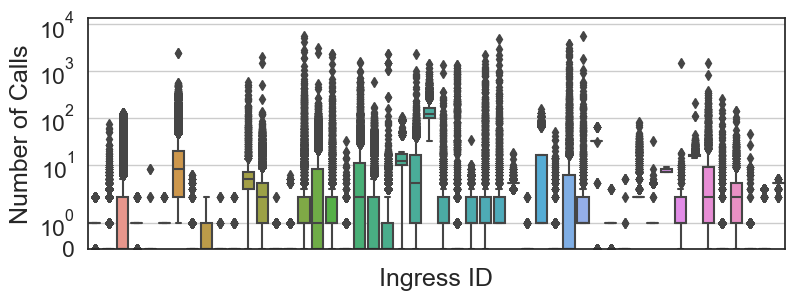

In [23]:
# get 50 parents with most records (to plot)
services = ads_parents_variable_relays.nlargest(50, 'count')['parent_name'].tolist()[:50]
filtered_services = ads_parent_data[ads_parent_data['parent_name'].isin(services)]

fig, ax = plt.subplots(figsize=(9, 3))
sns.boxplot(x="parent_name", y='num_calls', ax=ax, data=filtered_services, order=services)
plt.yscale('symlog')
plt.ylabel('Number of Calls')
plt.xlabel('Ingress ID')
plt.ylim(0, n_calls_max * 1.2)

ax.grid(axis='y')
ax.set_xticklabels([])
plt.show()

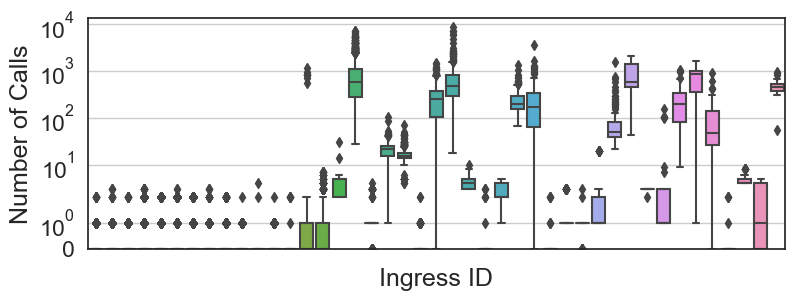

In [24]:
# get 50 parents with most records (to plot)
services = fetch_parents_variable_relays.nlargest(50, 'count')['parent_name'].tolist()[:50]
filtered_services = fetch_parent_data[fetch_parent_data['parent_name'].isin(services)]

fig, ax = plt.subplots(figsize=(9, 3))
sns.boxplot(x="parent_name", y='num_calls', ax=ax, data=filtered_services, order=services)
plt.yscale('symlog')
plt.ylabel('Number of Calls')
plt.xlabel('Ingress ID')
plt.ylim(0, n_calls_max * 1.2)

ax.grid(axis='y')
ax.set_xticklabels([])
plt.show()

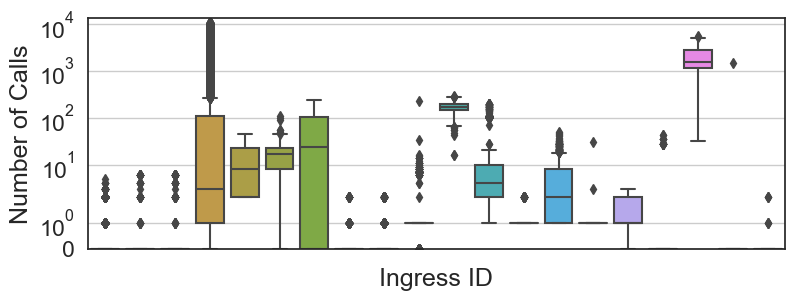

In [25]:
# get 50 parents with most records (to plot)
services = raas_parents_variable_relays.nlargest(50, 'count')['parent_name'].tolist()[:50]
filtered_services = raas_parent_data[raas_parent_data['parent_name'].isin(services)]

fig, ax = plt.subplots(figsize=(9, 3))
sns.boxplot(x="parent_name", y='num_calls', ax=ax, data=filtered_services, order=services)
plt.yscale('symlog')
plt.ylabel('Number of Calls')
plt.xlabel('Ingress ID')
plt.ylim(0, n_calls_max * 1.2)

ax.grid(axis='y')
ax.set_xticklabels([])
plt.show()

## Figure 15: Parent concurrency

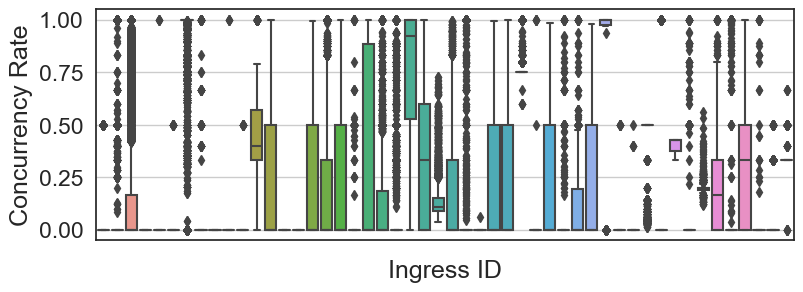

In [26]:
# get 50 parents with most records (to plot)
services = ads_parents_variable_relays.nlargest(50, 'count')['parent_name'].tolist()[:50]
filtered_services = ads_parent_data[ads_parent_data['parent_name'].isin(services)]

fig, ax = plt.subplots(figsize=(9, 3))
sns.boxplot(x="parent_name", y='concurrency_rate', ax=ax, data=filtered_services, order=services)
ax.set_ylabel("Concurrency Rate")
plt.xlabel('Ingress ID')

ax.grid(axis='y')
ax.set_xticklabels([])
plt.show()

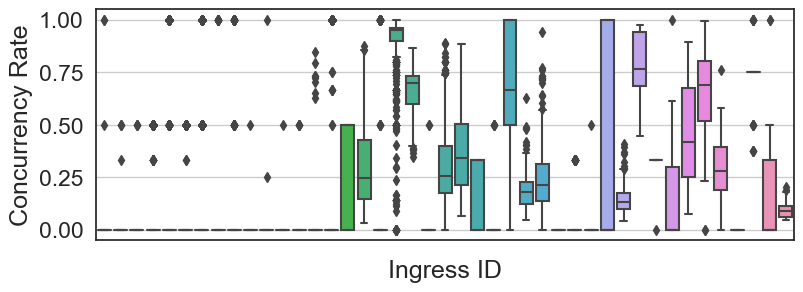

In [27]:
# get 50 parents with most records (to plot)
services = fetch_parents_variable_relays.nlargest(50, 'count')['parent_name'].tolist()[:50]
filtered_services = fetch_parent_data[fetch_parent_data['parent_name'].isin(services)]

fig, ax = plt.subplots(figsize=(9, 3))
sns.boxplot(x="parent_name", y='concurrency_rate', ax=ax, data=filtered_services, order=services)
ax.set_ylabel("Concurrency Rate")
plt.xlabel('Ingress ID')

ax.grid(axis='y')
ax.set_xticklabels([])
plt.show()

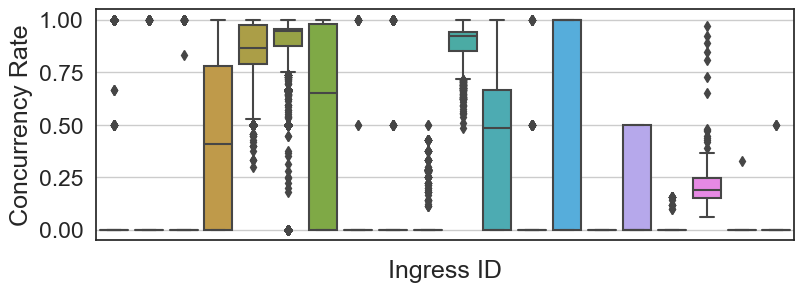

In [28]:
# get 50 parents with most records (to plot)
services = raas_parents_variable_relays.nlargest(50, 'count')['parent_name'].tolist()[:50]
filtered_services = raas_parent_data[raas_parent_data['parent_name'].isin(services)]

fig, ax = plt.subplots(figsize=(9, 3))
sns.boxplot(x="parent_name", y='concurrency_rate', ax=ax, data=filtered_services, order=services)
ax.set_ylabel("Concurrency Rate")
plt.xlabel('Ingress ID')

ax.grid(axis='y')
ax.set_xticklabels([])
plt.show()

## Figure 16: standard deviation in concurrency rate

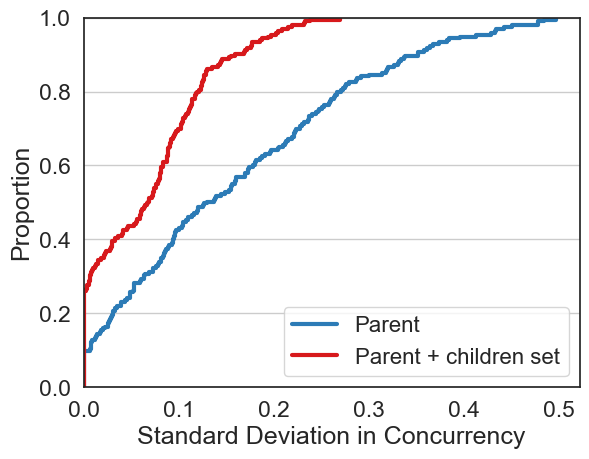

In [29]:
fig, ax = plt.subplots()

# calculate average std in concurrency for children sets of a parent
ads_parent_avg_cset_std = ads_parent_children_sets.groupby(["parent_name"], as_index=False).agg({'std_concurrency_cset': 'mean'}).rename(columns={'std_concurrency_cset': 'avg_std_cset'})

ax = sns.ecdfplot(data=ads_parents_variable_relays, x="std_concurrency", ax=ax, color=c3, linewidth=width, label="Parent")
ax = sns.ecdfplot(data=ads_parent_avg_cset_std, x="avg_std_cset", ax=ax, color=c1, linewidth=width, label="Parent + children set")

plt.xlim(0)
plt.legend(fontsize=legend_font)
plt.xlabel("Standard Deviation in Concurrency")

ax.grid(axis="y")
plt.show()

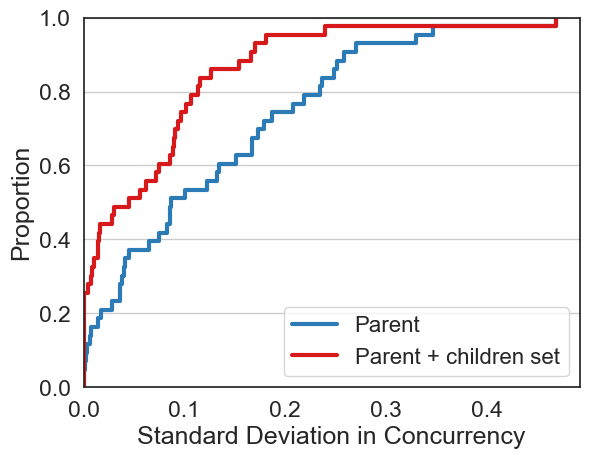

In [30]:
fig, ax = plt.subplots()

# calculate average std in concurrency for children sets of a parent
fetch_parent_avg_cset_std = fetch_parent_children_sets.groupby(["parent_name"], as_index=False).agg({'std_concurrency_cset': 'mean'}).rename(columns={'std_concurrency_cset': 'avg_std_cset'})

ax = sns.ecdfplot(data=fetch_parents_variable_relays, x="std_concurrency", ax=ax, color=c3, linewidth=width, label="Parent")
ax = sns.ecdfplot(data=fetch_parent_avg_cset_std, x="avg_std_cset", ax=ax, color=c1, linewidth=width, label="Parent + children set")

plt.xlim(0)
plt.legend(fontsize=legend_font)
plt.xlabel("Standard Deviation in Concurrency")

ax.grid(axis="y")
plt.show()

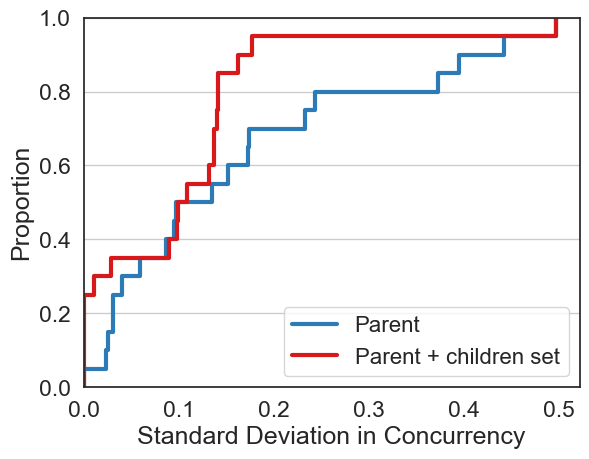

In [31]:
fig, ax = plt.subplots()

# calculate average std in concurrency for children sets of a parent
raas_parent_avg_cset_std = raas_parent_children_sets.groupby(["parent_name"], as_index=False).agg({'std_concurrency_cset': 'mean'}).rename(columns={'std_concurrency_cset': 'avg_std_cset'})

ax = sns.ecdfplot(data=raas_parents_variable_relays, x="std_concurrency", ax=ax, color=c3, linewidth=width, label="Parent")
ax = sns.ecdfplot(data=raas_parent_avg_cset_std, x="avg_std_cset", ax=ax, color=c1, linewidth=width, label="Parent + children set")

plt.xlim(0)
plt.legend(fontsize=legend_font)
plt.xlabel("Standard Deviation in Concurrency")

ax.grid(axis="y")
plt.show()

## Figure 17: Parent ingress ID + children set max concurrency rate

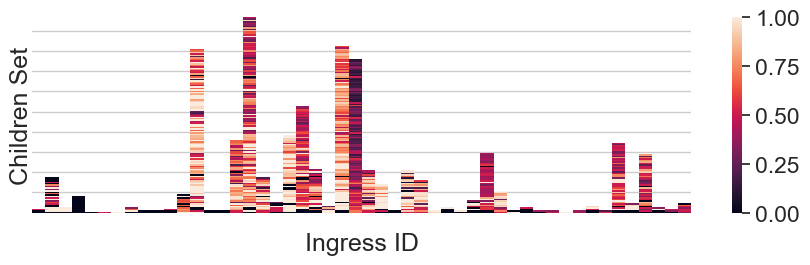

In [32]:
# get 50 parents with most records (to plot)
parents = ads_parents_variable_relays.nlargest(50, 'count')['parent_name'].tolist()[:50]

# sort parents by instance counts, filter out cells (parent + children set with less than 5 instances)
ads_parent_children_sets_filtered = ads_parent_children_sets[ads_parent_children_sets['parent_name'].isin(parents)]
ads_parent_children_sets_filtered = ads_parent_children_sets_filtered[ads_parent_children_sets_filtered['count'] > 4].sort_values(by=['count'], ascending=False)

# rank by instance counts
ads_parent_children_sets_filtered['parent_rank'] =  ads_parent_children_sets_filtered['parent_name'].apply(lambda x: parents.index(x))

plot_data = ads_parent_children_sets_filtered[['c_set_index', 'parent_rank', 'max_concurrency_cset']].pivot_table(index='c_set_index', columns='parent_rank', values='max_concurrency_cset')

fig, ax = plt.subplots(figsize=(9, 3))
ax = sns.heatmap(plot_data, ax=ax)
ax.invert_yaxis()

plt.xlabel('Ingress ID')
plt.ylabel("Children Set", labelpad=-10)
ax.grid(axis='y')

ax.set_xticklabels([])
ax.set_yticklabels([])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

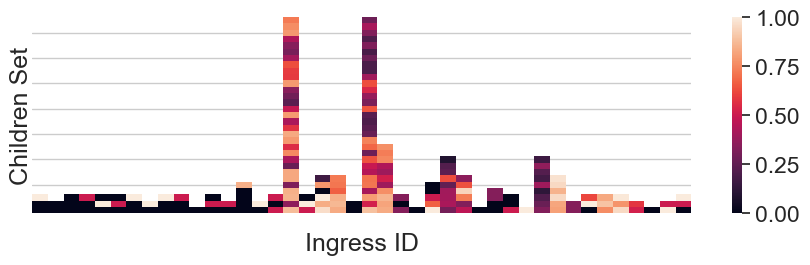

In [33]:
# get 50 parents with most records (to plot)
parents = fetch_parents_variable_relays.nlargest(50, 'count')['parent_name'].tolist()[:50]

# sort parents by instance counts, filter out cells (parent + children set with less than 5 instances)
fetch_parent_children_sets_filtered = fetch_parent_children_sets[fetch_parent_children_sets['parent_name'].isin(parents)]
fetch_parent_children_sets_filtered = fetch_parent_children_sets_filtered[fetch_parent_children_sets_filtered['count'] > 4].sort_values(by=['count'], ascending=False)

# rank by instance counts
fetch_parent_children_sets_filtered['parent_rank'] =  fetch_parent_children_sets_filtered['parent_name'].apply(lambda x: parents.index(x))

plot_data = fetch_parent_children_sets_filtered[['c_set_index', 'parent_rank', 'max_concurrency_cset']].pivot_table(index='c_set_index', columns='parent_rank', values='max_concurrency_cset')

fig, ax = plt.subplots(figsize=(9, 3))
ax = sns.heatmap(plot_data, ax=ax)
ax.invert_yaxis()

plt.xlabel('Ingress ID')
plt.ylabel("Children Set", labelpad=-10)
ax.grid(axis='y')

ax.set_xticklabels([])
ax.set_yticklabels([])
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

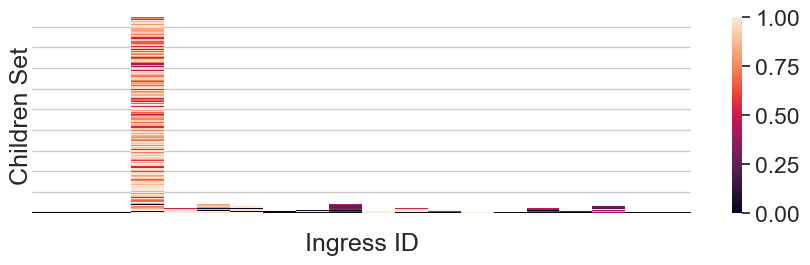

In [34]:
# get 50 parents with most records (to plot)
parents = raas_parents_variable_relays.nlargest(50, 'count')['parent_name'].tolist()[:50]

# sort parents by instance counts, filter out cells (parent + children set with less than 5 instances)
raas_parent_children_sets_filtered = raas_parent_children_sets[raas_parent_children_sets['parent_name'].isin(parents)]
raas_parent_children_sets_filtered = raas_parent_children_sets_filtered[raas_parent_children_sets_filtered['count'] > 4].sort_values(by=['count'], ascending=False)

# rank by instance counts
raas_parent_children_sets_filtered['parent_rank'] =  raas_parent_children_sets_filtered['parent_name'].apply(lambda x: parents.index(x))

plot_data = raas_parent_children_sets_filtered[['c_set_index', 'parent_rank', 'max_concurrency_cset']].pivot_table(index='c_set_index', columns='parent_rank', values='max_concurrency_cset')

fig, ax = plt.subplots(figsize=(9, 3))
ax = sns.heatmap(plot_data, ax=ax)
ax.invert_yaxis()

plt.xlabel('Ingress ID')
plt.ylabel("Children Set", labelpad=-10)
ax.grid(axis='y')

ax.set_xticklabels([])
ax.set_yticklabels([])
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

## Figure 18: Inferred Services

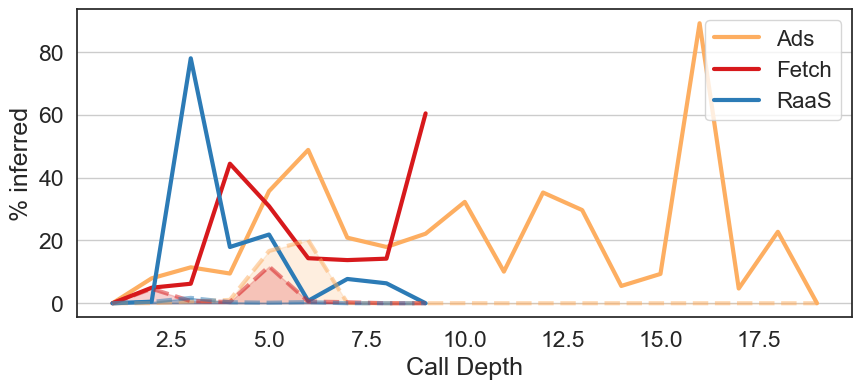

In [35]:
inferred_path_data_ads = inferred_path_data[inferred_path_data['profile'] == 'ads'].sort_values('call_depth')
inferred_path_data_fetch = inferred_path_data[inferred_path_data['profile'] == 'fetch'].sort_values('call_depth')
inferred_path_data_raas = inferred_path_data[inferred_path_data['profile'] == 'raas'].sort_values('call_depth')

fig, ax = plt.subplots(figsize=(10, 4))


plt.plot(inferred_path_data_ads['call_depth'], inferred_path_data_ads['percent_inferred_total'], linewidth=width, color=c2, label='Ads')
plt.plot(inferred_path_data_fetch['call_depth'], inferred_path_data_fetch['percent_inferred_total'], linewidth=width, color=c1, label='Fetch')
plt.plot(inferred_path_data_raas['call_depth'], inferred_path_data_raas['percent_inferred_total'], linewidth=width, color=c3, label='RaaS')

plt.plot(inferred_path_data_ads['call_depth'], inferred_path_data_ads['percent_inferred_known'], linewidth=width, linestyle ='dashed', color=c2, alpha=0.5)
plt.plot(inferred_path_data_fetch['call_depth'], inferred_path_data_fetch['percent_inferred_known'], linewidth=width, linestyle ='dashed',color=c1, alpha=0.5)
plt.plot(inferred_path_data_raas['call_depth'], inferred_path_data_raas['percent_inferred_known'], linewidth=width, linestyle ='dashed',color=c3, alpha=0.5)

plt.fill_between(x= inferred_path_data_ads['call_depth'], y1= inferred_path_data_ads['percent_inferred_known'], color= c2, alpha= 0.2)
plt.fill_between(x= inferred_path_data_fetch['call_depth'], y1= inferred_path_data_fetch['percent_inferred_known'], color= c1, alpha= 0.2)
plt.fill_between(x= inferred_path_data_raas['call_depth'], y1= inferred_path_data_raas['percent_inferred_known'], color= c3, alpha= 0.4)

plt.ylabel('% inferred')
plt.xlabel('Call Depth')
plt.legend(fontsize=legend_font)
ax.grid(axis='y')
plt.show()